Fit the 6 ratio datasets at once to autonomous model. Goal is to have comparison that justifies nonautonomous model.

In [1]:
import numpy as np
from scipy.integrate import odeint #For ODE integration
import matplotlib.pyplot as plt #For plotting
import pymc as pm
from pymc.ode import DifferentialEquation
import arviz as az

In [2]:
# Set parameter for nondimensionalizing time and concentration later on
gammaamax=2.3
km=.006


Load experimental data from excel file:

In [3]:
import pandas as pd
file_name =  '/Users/amanda/Documents/MATLAB/auxotroph_ratio_control_summary.xlsx' # path to file + file name

#Define function that loads data from each experiment and returns a vector of t values and a vector of r values
def loadData(sheet1, sheet2, sheet3):
    
    df1 = pd.read_excel(io=file_name, sheet_name=sheet1)
    df2 = pd.read_excel(io=file_name, sheet_name=sheet2)
    df3 = pd.read_excel(io=file_name, sheet_name=sheet3)

    combined_df = pd.concat([df1,df2,df3], ignore_index=True)

    combined_df_sorted = combined_df.sort_values(by='Time')

    data=combined_df_sorted.to_numpy()
    lb_avg=(data[:,1]+data[:,2]+data[:,3])/3
    m_avg=(data[:,4]+data[:,5]+data[:,6])/3
    rdata=m_avg/lb_avg
    # Replace entries greater than 1 with 1
    rdata[rdata > 1] = 1
    
    #rescale time by \gamma_{a,max}
    tdata = data[:,0]/60/60*gammaamax

    return tdata, rdata


In [ ]:
tdata_unsupp50,rdata_unsupp50=loadData('metAargC-1','metAargC-2','metAargC-3')
tdata_unsupp99,rdata_unsupp99=loadData('metAargC-99-1-1','metAargC-99-1-2','metAargC-99-1-3')
tdata_unsupp1,rdata_unsupp1=loadData('metAargC-1-99-1','metAargC-1-99-2','metAargC-1-99-3')
tdata1_1,rdata1_1=loadData('metAargC-1uMargmet-1','metAargC-1uMargmet-2','metAargC-1uMargmet-3')
tdata10_10,rdata10_10=loadData('metAargC-10uMarg-10nMmet-1','metAargC-10uMarg-10nMmet-2','metAargC-10uMarg-10nMmet-3')
tdata10_5,rdata10_5=loadData('metAargC-10uMarg-5nMmet-1','metAargC-10uMarg-5nMmet-2','metAargC-10uMarg-5nMmet-3')


Define ODE models to use in PyMC

In [5]:
#Define the ODE systems in the following function

def KmAuxRatio_unsupp(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    alpha=0/km #no supplemented Arg
    m=0/km

    # Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    return dcmdt,dyadt,dymdt



def KmAuxRatio1_1(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    
    alpha=1/km #1\mu M supplemented Arg
    m=1/km
    
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt

def KmAuxRatio10_10(x, t, p):
    #Unpack state variables 
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    
    alpha=10/km 
    m=0.01/(km)
    
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    return dcmdt,dyadt,dymdt

def KmAuxRatio10_5(x, t, p):
    #Unpack state variables
    
    cm=x[0]
    ya=x[1]
    ym=x[2]
    #Unpack unknown params
    baprime=p[0]
    bmprime=p[1]
    etaaprime=p[2]
    etamprime=p[3]
    gamma=p[4]
    K=p[5]
    ba=p[6]
    bm=p[7]
    
    
    alpha=10/km #no supplemented Arg
    
    m=0.005/km
    
    ## Model
    dcmdt=(gamma * ym**bm) / (1 + ym**bm)*cm-((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))*cm
    dyadt = baprime * cm - etaaprime * ((ya**ba) / (K**ba + ya**ba)) *(1-cm) -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ya-alpha)
    dymdt = bmprime * (1-cm) - etamprime * (gamma * ym**bm) / (1 + ym**bm) * cm -((((ya**ba) / (K**ba + ya**ba))*(1-cm)+(gamma * ym**bm) / (1 + ym**bm)*cm))* (ym-m)

    
    return dcmdt,dyadt,dymdt




In [6]:
t0=0 #initial time

x_0_unsupp50 = [.5,150,150]#[cm_initial,ya_initial,ym_initial] 
x_0_unsupp99 = [.95,150,150]
x_0_unsupp1 = [.05,150,150]
x_0_1_1 = [.5,150,150]
x_0_10_10 = [.5,150,150]
x_0_10_5 = [.5,150,150]


ode_model_unsupp50 = DifferentialEquation(func=KmAuxRatio_unsupp, times=tdata_unsupp50, n_states=3, n_theta=8, t0=t0)
ode_model_unsupp99 = DifferentialEquation(func=KmAuxRatio_unsupp, times=tdata_unsupp99, n_states=3, n_theta=8, t0=t0)
ode_model_unsupp1 = DifferentialEquation(func=KmAuxRatio_unsupp, times=tdata_unsupp1, n_states=3, n_theta=8, t0=t0)

ode_model1_1 = DifferentialEquation(func=KmAuxRatio1_1, times=tdata1_1, n_states=3, n_theta=8, t0=t0)
ode_model10_10 = DifferentialEquation(func=KmAuxRatio10_10, times=tdata10_10, n_states=3, n_theta=8, t0=t0)
ode_model10_5 = DifferentialEquation(func=KmAuxRatio10_5, times=tdata10_5, n_states=3, n_theta=8, t0=t0)





Use DEMetropolisZ to fit model to data

In [7]:
with pm.Model() as model:

    # Specify prior distributions for our model parameters
    baprime=pm.Gamma('baprime', mu=100,sigma=50)
    bmprime=pm.Gamma('bmprime', mu=1,sigma=1)
    etaaprime=pm.Gamma('etaaprime', mu=.1,sigma=.2)
    etamprime=pm.Gamma('etamprime', mu=.1,sigma=.2)
    gamma=pm.Uniform('gamma', lower=.5,upper=2)
    K=pm.Gamma('K', mu=700, sigma=250)
    ba=pm.Uniform('ba', lower=.5,upper=10)
    bm=pm.Uniform('bm', lower=.5,upper=10)

    # Specifiy prior distribution for observational noise
    sigma = pm.HalfNormal('sigma', 1)


    ode_solution_unsupp50 = ode_model_unsupp50(y0=x_0_unsupp50, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution_unsupp99 = ode_model_unsupp99(y0=x_0_unsupp99, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution_unsupp1 = ode_model_unsupp1(y0=x_0_unsupp1, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution1_1 = ode_model1_1(y0=x_0_1_1, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution10_10 = ode_model10_10(y0=x_0_10_10, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])
    ode_solution10_5 = ode_model10_5(y0=x_0_10_5, theta=[baprime, bmprime,etaaprime,etamprime,gamma,K,ba,bm])

    #Define likelihood
    Y1 = pm.Normal("Y1", mu=ode_solution_unsupp50[:,0], sigma=sigma, observed=rdata_unsupp50)
    Y2 = pm.Normal("Y2", mu=ode_solution_unsupp99[:,0], sigma=sigma, observed=rdata_unsupp99)
    Y3 = pm.Normal("Y3", mu=ode_solution_unsupp1[:,0], sigma=sigma, observed=rdata_unsupp1)
    Y4 = pm.Normal("Y4", mu=ode_solution1_1[:,0], sigma=sigma, observed=rdata1_1)
    Y5 = pm.Normal("Y5", mu=ode_solution10_10[:,0], sigma=sigma, observed=rdata10_10)
    Y6 = pm.Normal("Y6", mu=ode_solution10_5[:,0], sigma=sigma, observed=rdata10_5)

    # Set custom initial values
    initvals = {"baprime": 70,"bmprime":1.5,"etaaprime":0.01,"etamprime":0.01,"gamma":1.05, "K":115, "ba":9, "bm":5, "sigma": 0.1}

    step = pm.DEMetropolisZ()

    trace = pm.sample(tune=6000, draws=6000, initvals=initvals, step=step)
    

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [baprime, bmprime, etaaprime, etamprime, gamma, K, ba, bm, sigma]


Sampling 4 chains for 6_000 tune and 6_000 draw iterations (24_000 + 24_000 draws total) took 13051 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


View posterior

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
baprime     65.026  10.792  45.669   84.970      0.984    0.697   123.030   
bmprime      1.418   0.095   1.247    1.603      0.004    0.003   459.121   
etaaprime    0.089   0.184   0.000    0.394      0.006    0.004   359.358   
etamprime    0.115   0.111   0.000    0.317      0.019    0.014    32.227   
gamma        1.018   0.003   1.011    1.024      0.000    0.000   384.578   
K          112.897  11.109  91.624  133.564      0.492    0.348   507.430   
ba           8.945   0.787   7.482    9.993      0.037    0.026   363.641   
bm           5.180   0.409   4.481    6.008      0.024    0.017   291.263   

           ess_tail  r_hat  
baprime     801.517  1.038  
bmprime     784.079  1.010  
etaaprime   406.985  1.006  
etamprime   255.245  1.108  
gamma       677.230  1.007  
K           696.842  1.008  
ba          362.694  1.006  
bm          483.856  1.026

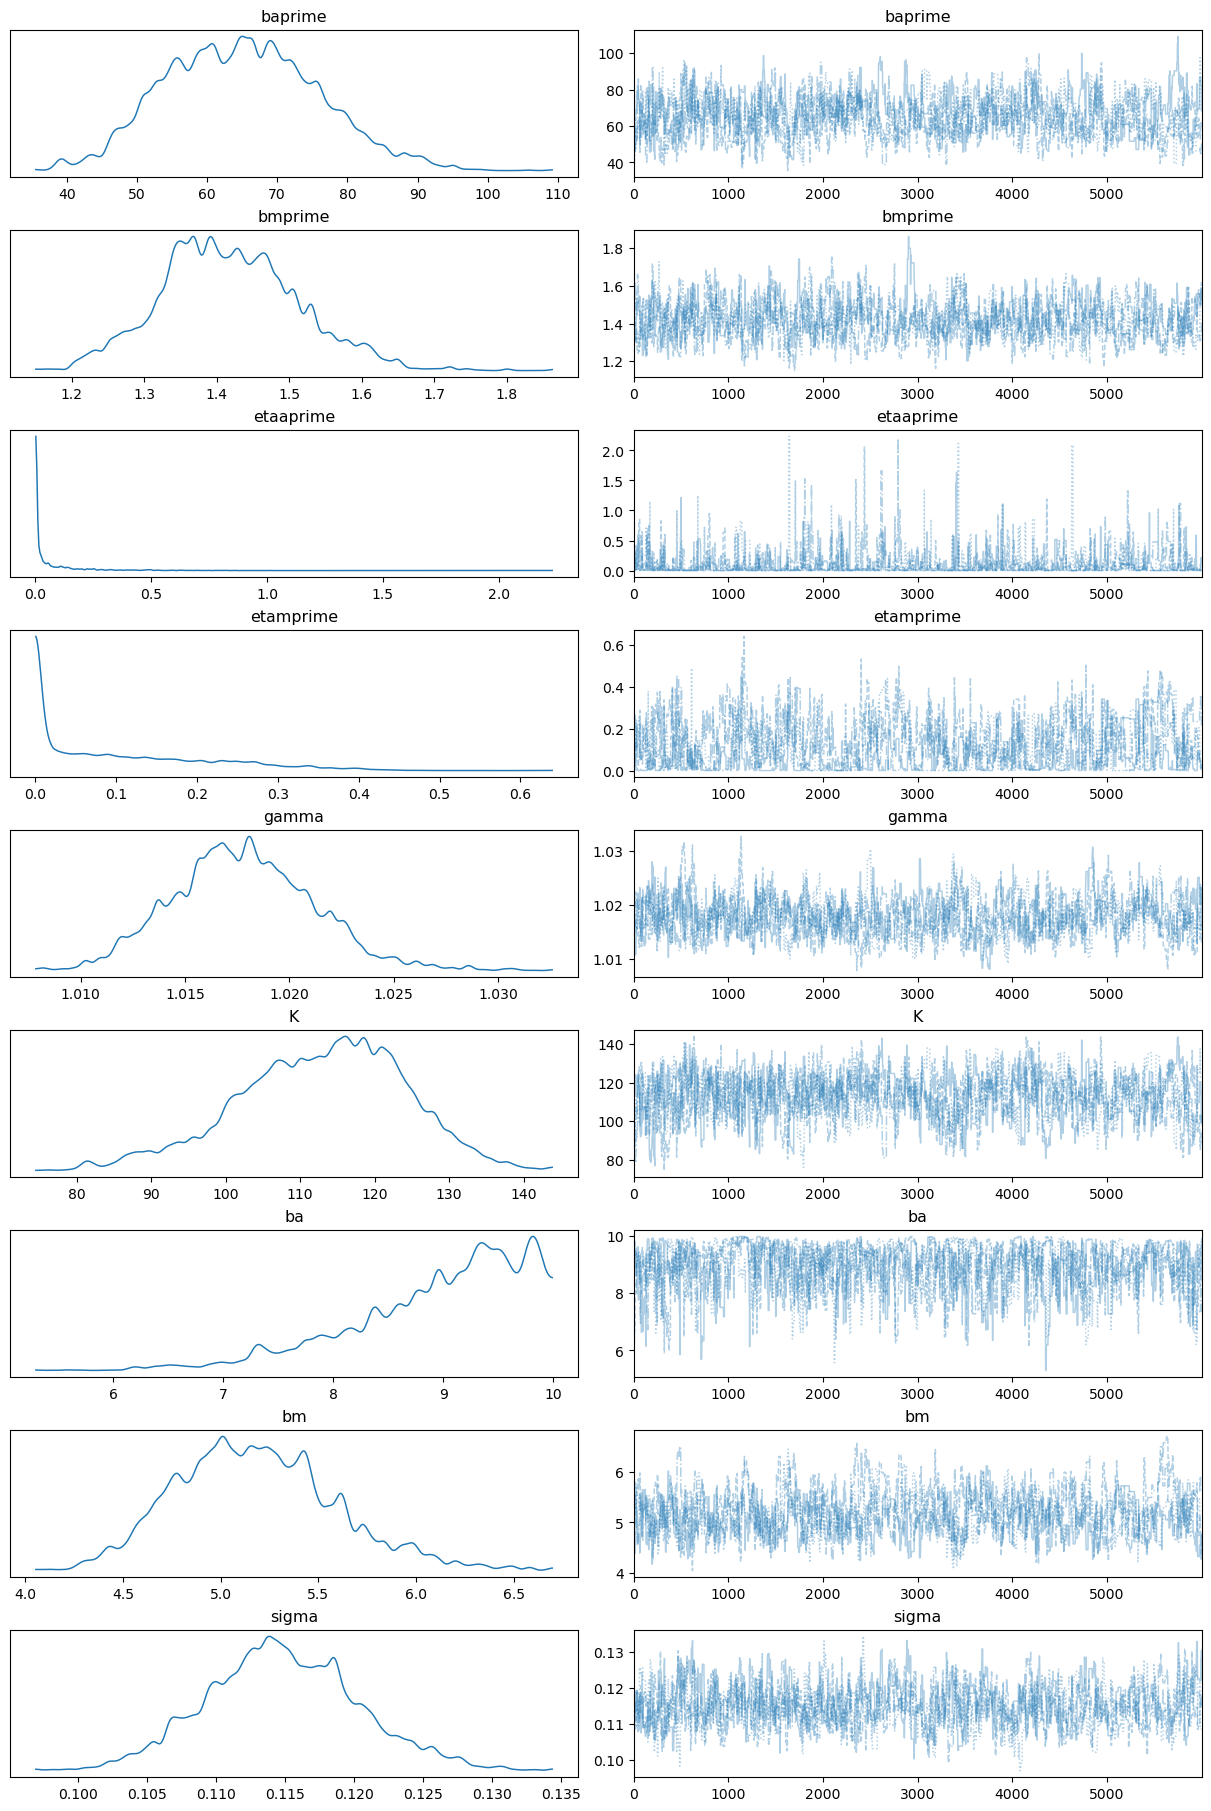

In [8]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(trace,combined=True);
az.summary(trace, var_names=["baprime","bmprime","etaaprime","etamprime","gamma", "K", "ba", "bm"], round_to=3)


/Users/amanda/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


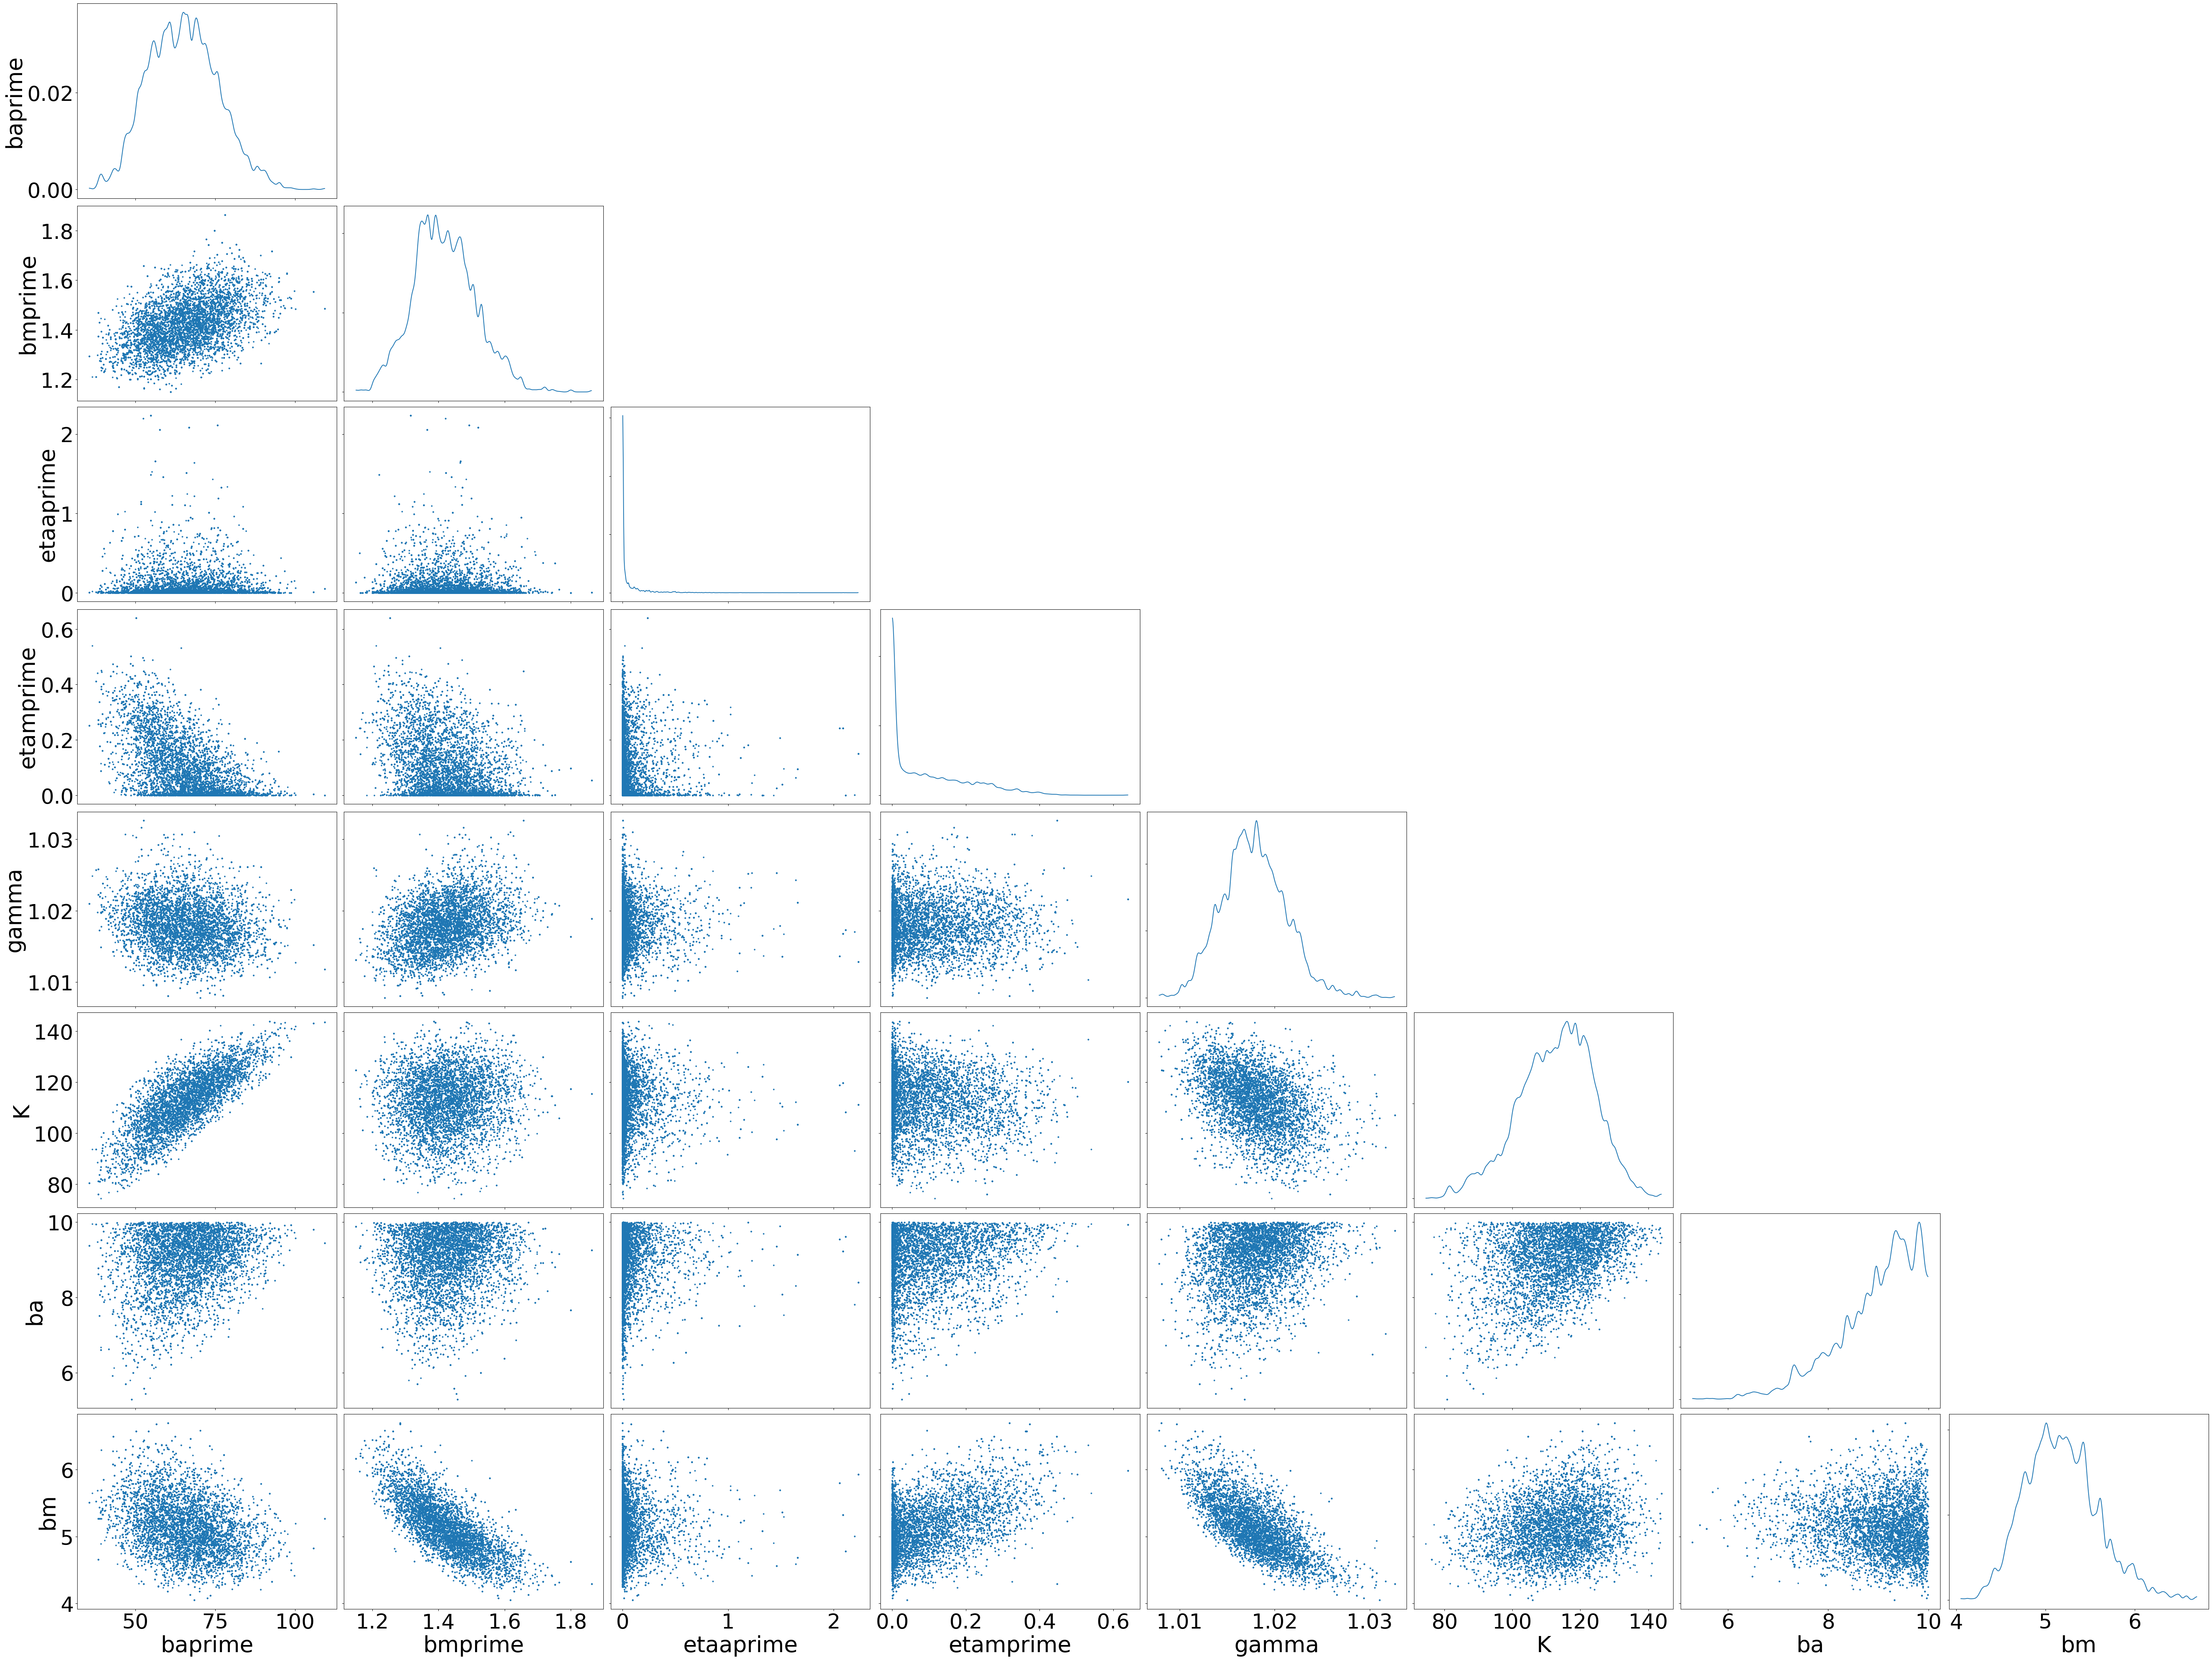

In [9]:
az.plot_pair(trace, var_names=['baprime','bmprime','etaaprime','etamprime','gamma','K','ba','bm'], marginals=True,textsize=40)


array([[<Axes: title={'center': 'baprime'}>,
        <Axes: title={'center': 'baprime'}>],
       [<Axes: title={'center': 'bmprime'}>,
        <Axes: title={'center': 'bmprime'}>],
       [<Axes: title={'center': 'etaaprime'}>,
        <Axes: title={'center': 'etaaprime'}>],
       [<Axes: title={'center': 'etamprime'}>,
        <Axes: title={'center': 'etamprime'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'K'}>, <Axes: title={'center': 'K'}>],
       [<Axes: title={'center': 'ba'}>, <Axes: title={'center': 'ba'}>],
       [<Axes: title={'center': 'bm'}>, <Axes: title={'center': 'bm'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

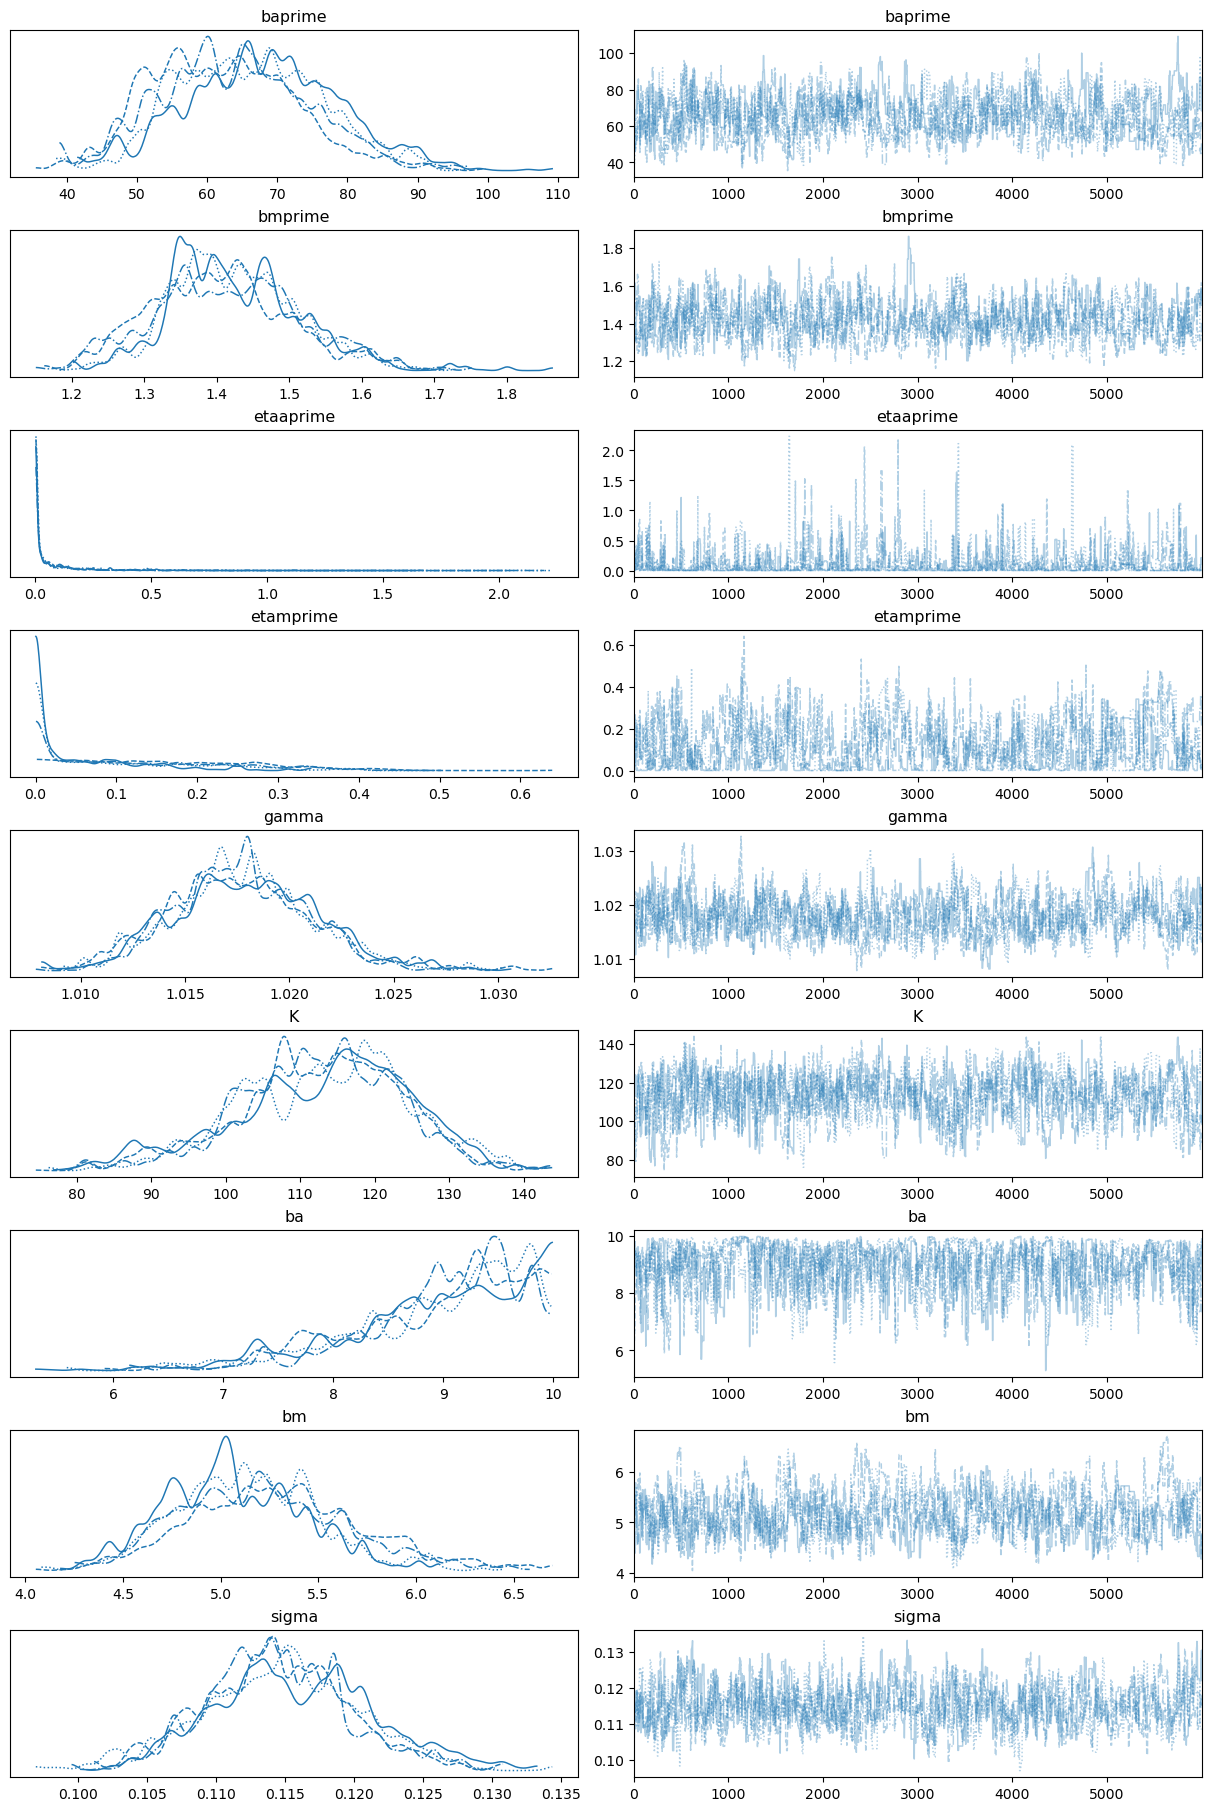

In [10]:
az.plot_trace(trace)